In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as ss
import tensorflow as tf
import math
import random

Parameter initialization

In [2]:
T=30/365
dt=1/365
N=round(T/dt)
t=np.linspace(0,T,N)
vol=0.2
r=0
cost=0.002
S0=100
cost=0.002

Generated sample paths by GBM model

In [3]:
path_num=300  #We set the number of the sample paths. Here we choose 300 for the sake of simplicity
path=[]
for i in range(path_num):
    rand=np.random.standard_normal(size=N)
    S=np.zeros_like(rand)
    S[0]=S0
    for i in range(1,N):
        S[i]=S[i-1]*np.exp((r-vol**2/2)*dt+vol*rand[i]*math.sqrt(dt))
    path.append(S)

In [4]:
path=np.array(path)

Visualized one of the sample

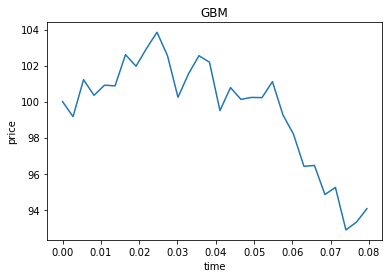

In [5]:
S_sam=path[0]
time=range(len(S_sam))
time=np.array(time)/365
plt.xlabel('time')
plt.ylabel('price')
plt.title(u'GBM')
plt.plot(time,S_sam)
plt.show()

Cost-adjusted volatility of Leland model

In [6]:
le_vol=np.sqrt(vol**2*(1+(2*cost/vol)*np.sqrt(2/(math.pi*dt))))
le_vol

0.22846192353303973

Calculated the option prices

In [7]:
path_diff=[]
for i in range(path_num):    
    S_diff=[]
    S_tem=path[i]
    for i in range(1,len(S_tem)):
        S_diff.append(S_tem[i]-S_tem[i-1])
    S_diff=np.array(S_diff)
    #S_diff=S_diff.reshape(-1,1)
    S_diff=np.float32(S_diff)
    path_diff.append(S_diff)
path_dif=np.array(path_diff)
path_dif.shape

(300, 29)

In [8]:
from math import log,sqrt,exp
from scipy.stats import norm

In [9]:
def call_option_pricer(spot,strike,maturity,r,vol):
    d1=(log(spot/strike)+(r+0.5*vol*vol)*maturity)/(vol*sqrt(maturity))
    d2=d1-vol*sqrt(maturity)
    price=spot*norm.cdf(d1)-strike*exp(-r*maturity)*norm.cdf(d2)
    return price

In [10]:
rever_t=sorted(range(N),reverse=True)
rever_t=rever_t[:-1]
rever_t=np.array(rever_t)/365
rever_t

array([0.07945205, 0.07671233, 0.0739726 , 0.07123288, 0.06849315,
       0.06575342, 0.0630137 , 0.06027397, 0.05753425, 0.05479452,
       0.05205479, 0.04931507, 0.04657534, 0.04383562, 0.04109589,
       0.03835616, 0.03561644, 0.03287671, 0.03013699, 0.02739726,
       0.02465753, 0.02191781, 0.01917808, 0.01643836, 0.01369863,
       0.0109589 , 0.00821918, 0.00547945, 0.00273973])

In [11]:
%%time
Option_sam=[]
for i in range(path_num):
    S=path[i]
    Option=[]
    for j in range(len(S)-1):
        price=call_option_pricer(S[j],100,rever_t[j],r,le_vol)
        Option.append(price)
    Option.append(max(S[-1]-S0,0))
    Option=np.array(Option)
    #Option=Option.reshape(-1,1)
    Option_sam.append(Option)

Wall time: 1.18 s


In [12]:
Option_samp=np.array(Option_sam)
Option_samp.shape

(300, 30)

In [13]:
Nd_nor=[]
for j in range(path_num):    
    d_nor=[]
    for i in range(len(rever_t)):
        par1=1.0/(le_vol*math.sqrt(rever_t[i]))
        par2=np.log(path[j][i]/S0)
        par3=(r+(le_vol**2)/2)*(rever_t[i])
        Nd=par1*(par2+par3)
        d_nor.append(ss.norm.cdf(Nd))
    Nd_nor.append(d_nor)

In [125]:
Nd_nor_diff=[]
for i in range(len(Nd_nor)):
    d_nor_diff=[Nd_nor[i][0]]
    for j in range(len(Nd_nor[i])-1):
        d_nor_diff.append(Nd_nor[i][j+1]-Nd_nor[i][j])
    Nd_nor_diff.append(d_nor_diff)
#Nd_nor_diff

In [15]:
hedge_set=[]
for i in range(path_num):
    hedge=[Option_samp[i][0].tolist()]
    for j in range(len(Nd_nor[i])):
        diff=path[i][j+1]-path[i][j]
        hold=Nd_nor[i][j]*diff-Nd_nor_diff[i][j]*cost*path[i][j+1]
        hedge.append(hold)
    
    hedge=np.cumsum(hedge).tolist()
    hedge_set.append(hedge)

In [16]:
hedge_set=np.array(hedge_set)

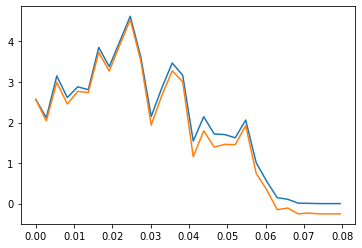

In [17]:
plt.plot(time,Option_samp[0])
plt.plot(time,hedge_set[0])
plt.show()

In [18]:
su1=0
num=0
for j in range(path_num):
    for i in range(len(Option_samp[int(j)])):
        k=Option_samp[int(j)][i].tolist()-hedge_set[int(j)][i]
        j=k**2
        su1+=j
        num+=1
su1/num

0.04382227854917361

Deep neural network for hedging with linear transaction cost

In [19]:
x_train=path[:,:-1]
x_train=x_train.reshape(x_train.shape[0],x_train.shape[1],1)
x_train.shape

(300, 29, 1)

In [20]:
import tensorflow as tf

In [49]:
RNN_CELLSIZE = 50
SEQLEN = x_train.shape[1]
BATCHSIZE = 1
LR = 0.005

In [50]:
class GRUModel(tf.keras.Model):
    def __init__(self, batch_size, seq_length, cell_size):
        super().__init__()
        self.batch_size = batch_size
        self.seq_length = seq_length
        self.cell_size = cell_size
    
        self.layer1 = tf.keras.layers.Reshape((self.seq_length,1), batch_size = self.batch_size)
        self.layer_GRU = tf.keras.layers.GRU(self.cell_size,activation='relu',return_sequences=True)
        self.layer_GRU_last = tf.keras.layers.GRU(self.cell_size,activation='relu')
        self.layer_dense = tf.keras.layers.Dense(29)
  
    def call(self, inputs):
        x = self.layer1(inputs)
        x = self.layer_GRU(x)
        x = self.layer_GRU_last(x)
        output = self.layer_dense(x)
        return output

In [51]:
def loss_function1(x,S_diff,option):
    diff=[]
    for j in range(option.shape[0]):        
        a=[option[j][0]]
        for i in range(len(x[j])):
            add=x[j][i]*S_diff[j][i]
            a.append(add)
        d=tf.cumsum(a)
        b=option[j]-d
        c=tf.abs(b[-1])
        diff.append(c)
    return diff

In [52]:
def loss_fun1(price):
    res=0
    for i in range(len(price)):
        e=np.percentile(price[i],50)
        ES=0
        n=0
        for j in range(len(price[i])):
            if tf.greater(price[i][j],e):
                ES+=price[i][j]
                n+=1
        ES1=ES/n
        res+=ES1
    res1=res/len(price)
    return res1

In [74]:
def loss_fun3(price):
    res=0
    for i in range(len(price)):
        e1=np.percentile(price[i],50)
        e2=np.percentile(price[i],90)
        beta=0.1
        ES1=0
        ES2=0
        m=0
        n=0
        for j in range(len(price[i])):
            if tf.greater(price[i][j],e1):
                ES1+=price[i][j]
                n+=1
            if tf.greater(price[i][j],e2):
                ES2+=price[i][j]
                m+=1
        ES11=ES1/n
        ES21=ES2/m
        con=(1.0/(1+beta))*(ES11+beta*ES21)
        res+=con
    res1=res/len(price)
    return res1

In [75]:
model = GRUModel(BATCHSIZE, SEQLEN,RNN_CELLSIZE)
optimizer = tf.keras.optimizers.Adam(learning_rate = LR)

In [76]:
for epoch in range(150):
    with tf.GradientTape() as tape:
        y_pred = model(x_train)
        #print(y_pred)
        price=loss_function1(y_pred, path_diff,Option_samp)
        loss=loss_fun3(price)
        if epoch%1 == 0:
            print("epoch: {}, loss: {}".format(epoch, loss))
  
    grads = tape.gradient(loss, model.variables)
    optimizer.apply_gradients(zip(grads,model.variables))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

epoch: 0, loss: 6.9618682861328125
epoch: 1, loss: 4.4572434425354
epoch: 2, loss: 3.243060350418091
epoch: 3, loss: 2.644430637359619
epoch: 4, loss: 2.2350640296936035
epoch: 5, loss: 1.872795820236206
epoch: 6, loss: 1.590617060661316
epoch: 7, loss: 1.428830623626709
epoch: 8, loss: 1.3311657905578613
epoch: 9, loss: 1.2766237258911133
epoch: 10, loss: 1.2420494556427002
epoch: 11, loss: 1.2208685874938965
epoch: 12, loss: 1.19405996799469
epoch: 13, loss: 1.1583164930343628
epoch: 14, loss: 1.13036

test sample

In [126]:
test_num=500  #We could set the number of test samples. Here we choose 500 test samples
test_path=[]
for i in range(test_num):
    rand=np.random.standard_normal(size=N)
    S=np.zeros_like(rand)
    S[0]=S0
    for i in range(1,N):
        S[i]=S[i-1]*np.exp((r-vol**2/2)*dt+vol*rand[i]*math.sqrt(dt))
    test_path.append(S)

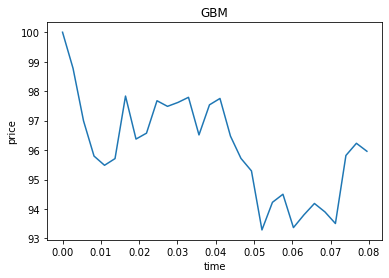

In [127]:
test_S_sam=test_path[0]
time=range(len(test_S_sam))
time=np.array(time)/365
plt.xlabel('time')
plt.ylabel('price')
plt.title(u'GBM')
plt.plot(time,test_S_sam)
plt.show()

In [128]:
test_path=np.array(test_path)
test_path.shape

(500, 30)

Leland model hedge

In [129]:
def call_option_price(spot,strike,maturity,r,vol):
    pricer=[]
    for i in range(len(spot)):
        pricer1=[]
        for j in range(len(spot[i])-1):
            spot1=spot[i][j]
            d1=(log(spot1/strike)+(r+0.5*vol*vol)*maturity[j])/(vol*sqrt(maturity[j]))
            d2=d1-vol*sqrt(maturity[j])
            price=spot1*norm.cdf(d1)-strike*exp(-r*maturity[j])*norm.cdf(d2)
            pricer1.append(price)
        pricer1.append(max(spot[i][-1]-100,0))
        pricer.append(pricer1)
    pricer=np.array(pricer)
    return pricer

In [130]:
%%time
test_Option_sam=call_option_price(test_path,100,rever_t,r,le_vol)
test_Option_sam

Wall time: 1.89 s


In [131]:
def hedge_ratio(path_num,rever_t,path,S0,vol,r):
    te=[]
    for j in range(path_num):    
        d_nor=[]
        for i in range(len(rever_t)):
            par1=1.0/(vol*math.sqrt(rever_t[i]))
            par2=np.log(path[j][i]/S0)
            par3=(r+(vol**2)/2)*(rever_t[i])
            Nd=par1*(par2+par3)
            d_nor.append(ss.norm.cdf(Nd))
        te.append(d_nor)
    return te

In [132]:
test_Nor=hedge_ratio(test_num,rever_t,test_path,S0,le_vol,r)

In [133]:
def hedge_set1(path_num,rever_t,Option_samp,Nd_nor,path):
    hedge_set=[]
    for i in range(path_num):
        hedge=[Option_samp[i][0].tolist()]
        for j in range(len(Nd_nor[i])):
            diff=path[i][j+1]-path[i][j]
            hold=Nd_nor[i][j]*diff
            hedge.append(hold)
    
        hedge=np.cumsum(hedge).tolist()
        hedge_set.append(hedge)
    hedge_set=np.array(hedge_set)
    return hedge_set

In [134]:
test_hedge=hedge_set1(test_num,rever_t,test_Option_sam,test_Nor,test_path)

Example of Leland model hedge

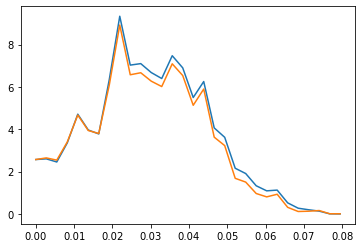

In [135]:
plt.plot(time,test_Option_sam[7])
plt.plot(time,test_hedge[7])
plt.show()

Mean squared hedging loss of Leland model hedge

In [136]:
su1=0
num=0
hist_model=[]
for j in range(test_num):
    for i in range(len(test_Option_sam[int(j)])):
        k=test_Option_sam[int(j)][i].tolist()-test_hedge[int(j)][i]
        hist_model.append(k)
        err=k**2
        su1+=err
        num+=1
su1/num

0.07524578662338532

network hedge

In [137]:
y_test=model.predict(test_path[:,:-1])

In [138]:
y_test.shape

(500, 29)

In [139]:
op_te=hedge_set1(test_num,rever_t,test_Option_sam,y_test,test_path)

Example of network hedge

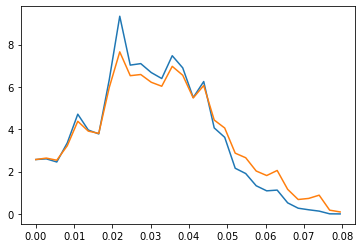

In [140]:
plt.plot(time,test_Option_sam[7])
plt.plot(time,op_te[7])
plt.show()

Mean squared hedging loss of network hedge

In [141]:
su1=0
num=0
hist_model1=[]
for j in range(test_num):
    for i in range(len(test_Option_sam[int(j)])):
        k=test_Option_sam[int(j)][i].tolist()-op_te[int(j)][i]
        hist_model1.append(k)
        err=k**2
        su1+=err
        num+=1
su1/num

0.5418610587193905

Distribution of mean squared hedging loss of Leland model hedge

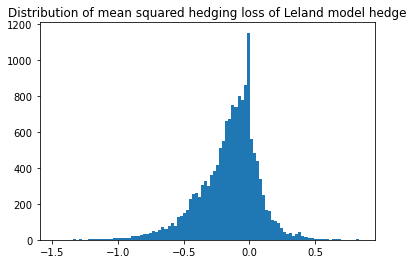

In [142]:
plt.hist(hist_model,bins=100)  #Distribution of mean squared hedging loss of Leland model hedge
plt.title('Distribution of mean squared hedging loss of Leland model hedge')
plt.show()

Distribution of mean squared hedging loss of network hedge

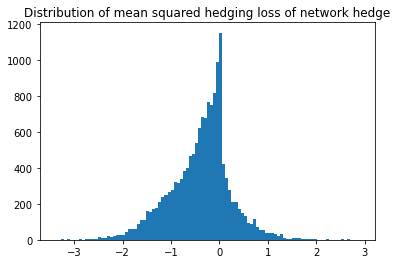

In [143]:
plt.hist(hist_model1,bins=100)  #Distribution of mean squared hedging loss of network hedge
plt.title('Distribution of mean squared hedging loss of network hedge')  
plt.show()

Since we only use 300 training samples to train the model, the mean squared hedging loss of network hedge is a bit larger than that of Leland model hedge. With the increasing number of training samples, network hedge will be able to replicate the Leland model hedge reasonably well and even outperforms the Leland model hedge with linear transaction costs.